In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# System
import os
import sys
sys.path.append('/home/helfrech/Tools/Toolbox/utils')

# Maths
import numpy as np
from numpy.random import default_rng

# Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ML
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.metrics import mean_squared_error, confusion_matrix

# Utilities
import project_utils as utils

In [3]:
# Load train set and CV indices for Deem
deem_train_idxs = np.loadtxt('../Processed_Data/DEEM_330k/train.idxs', dtype=int)
deem_test_idxs = np.loadtxt('../Processed_Data/DEEM_330k/test.idxs', dtype=int)

In [4]:
# Load train set and CV indices for IZA
iza_train_idxs = np.loadtxt('../Processed_Data/IZA_230/train.idxs', dtype=int)
iza_test_idxs = np.loadtxt('../Processed_Data/IZA_230/test.idxs', dtype=int)

In [5]:
model_dir = '../Processed_Data/Models'

deem_name = 'DEEM_330k'
iza_name = 'IZA_230'
deem_dir = f'../Processed_Data/{deem_name}/Data'
iza_dir = f'../Processed_Data/{iza_name}/Data'

In [6]:
# Load SOAPs
iza_file = f'{iza_dir}/6.0/soaps_power_full_avg_nonorm.hdf5'
iza_soaps = utils.load_hdf5(iza_file)
iza_train = iza_soaps[iza_train_idxs]
iza_test = iza_soaps[iza_test_idxs]

deem_file = f'{deem_dir}/6.0/soaps_power_full_avg_nonorm.hdf5'
deem_train = utils.load_hdf5(deem_file, indices=deem_train_idxs)
sort_idxs = np.argsort(deem_test_idxs)
rev_idxs = np.argsort(sort_idxs)
deem_test = utils.load_hdf5(deem_file, indices=deem_test_idxs[sort_idxs])
deem_test = deem_test[rev_idxs]

In [7]:
# Load properties
deem_energies = np.loadtxt('../Processed_Data/DEEM_330k/Data/structure_energies.dat')
deem_energies_train = deem_energies[deem_train_idxs]
deem_energies_test = deem_energies[deem_test_idxs]

iza_energies = np.loadtxt('../Processed_Data/IZA_230/Data/structure_energies.dat')
iza_energies_train = iza_energies[iza_train_idxs]
iza_energies_test = iza_energies[iza_test_idxs]

In [8]:
# Load cantons
deem_cantons = np.loadtxt('../Processed_Data/DEEM_330k/Data/cantons_2-class.dat', dtype=int)
deem_cantons_train = deem_cantons[deem_train_idxs]
deem_cantons_test = deem_cantons[deem_test_idxs]

iza_cantons = np.ones(len(iza_energies))
iza_cantons_train = iza_cantons[iza_train_idxs]
iza_cantons_test = iza_cantons[iza_test_idxs]

In [9]:
n_train_iza = len(iza_train_idxs)
n_train_deem = [np.minimum(len(deem_train_idxs), i*n_train_iza) for i in range(1, 100, 10)]

n_test_iza = len(iza_test_idxs)
n_test_deem = len(deem_test_idxs)

In [10]:
x_plot = [n / n_train_iza for n in n_train_deem]

In [65]:
X_test = np.vstack((iza_test, deem_test))
y_test = np.concatenate((iza_energies_test, deem_energies_test))
yc_test = np.concatenate((iza_cantons_test, deem_cantons_test))

# Linear Regression

In [12]:
rmse_train = np.zeros(len(n_train_deem))
rmse_train_deem = np.zeros(len(n_train_deem))
rmse_train_iza = np.zeros(len(n_train_deem))
rmse_test = np.zeros(len(n_train_deem))
rmse_test_deem = np.zeros(len(n_train_deem))
rmse_test_iza = np.zeros(len(n_train_deem))

In [13]:
for ndx, n in enumerate(n_train_deem[-1:]):
    idxs = np.arange(0, len(deem_train))
    np.random.shuffle(idxs)
    idxs = idxs[0:n]
        
    X_train = np.vstack((iza_train, deem_train[idxs]))
    y_train = np.concatenate((iza_energies_train, deem_energies_train[idxs]))
    
    wts_iza = np.ones(len(iza_train)) * len(X_train) / len(iza_train)
    wts_deem = np.ones(len(deem_train[idxs])) * len(X_train) / len(deem_train[idxs])
    wts = np.concatenate((wts_iza, wts_deem))
    wts /= np.sum(wts)
    #wts = np.ones(len(X_train))
    
    #X_mean = 0.0
    #X_mean = np.mean(X_train, axis=0)
    #X_mean = 0.5 * (np.mean(iza_train, axis=0) + np.mean(deem_train[idxs], axis=0))
    X_mean = np.average(X_train, weights=wts, axis=0)
    
    #X_scale = 1.0
    X_scale = np.sqrt(np.sum(np.var(X_train - X_mean, axis=0)))
    #X_scale = np.linalg.norm(X_train - X_mean)
    
    #y_mean = 0.0
    #y_mean = np.mean(y_train, axis=0)
    #y_mean = 0.5 * (np.mean(iza_energies_train) + np.mean(deem_energies_train))
    y_mean = np.average(y_train, weights=wts, axis=0)
    
    #yscale = 1.0
    y_scale = np.sqrt(np.sum(np.var(y_train - y_mean, axis=0)))
    #y_scale = np.linalg.norm(y_train - y_mean)
    
    # Must center beforehand and enforce fit_intercept=False and normalize=False
    # otherwise the centered/scaled data is recentered/rescaled.
    # This isn't an issue unless we care about machine precision errors
    # and/or use a non-L2 scaling (in which case we need normalize=False)
    ridge = Ridge(alpha=1.0E-12, fit_intercept=True, normalize=False, random_state=0)
    ridge.fit(
        (X_train - X_mean) / X_scale,
        (y_train - y_mean) / y_scale,
        sample_weight=wts
    )
    
    wridge = Ridge(alpha=1.0E-12, fit_intercept=False, normalize=False, random_state=0)
    wridge.fit(
        np.sqrt(wts)[:, np.newaxis] * (X_train - X_mean) / X_scale, 
        np.sqrt(wts) * (y_train - y_mean) / y_scale, 
        sample_weight=None
    )
    
    print('Unweighted')
    print(ridge.predict((X_test[0:5] - X_mean) / X_scale) * y_scale + y_mean)
    print('Weighted')
    print(wridge.predict((X_test[0:5] - X_mean) / X_scale) * y_scale + y_mean)

    yp_train = ridge.predict((X_train - X_mean) / X_scale)
    yp_test = ridge.predict((X_test - X_mean) / X_scale)
    wyp_train = wridge.predict((X_train - X_mean) / X_scale)
    wyp_test = wridge.predict((X_test - X_mean) / X_scale)
    
    rmse_train[ndx] = mean_squared_error(y_train, yp_train * y_scale + y_mean, squared=False)
    rmse_train_iza[ndx] = mean_squared_error(y_train[0:n_train_iza], yp_train[0:n_train_iza] * y_scale + y_mean)
    rmse_train_deem[ndx] = mean_squared_error(y_train[n_train_iza:], yp_train[n_train_iza:] * y_scale + y_mean)

    rmse_test[ndx] = mean_squared_error(y_test, yp_test * y_scale + y_mean, squared=False)
    rmse_test_iza[ndx] = mean_squared_error(y_test[0:n_test_iza], yp_test[0:n_test_iza] * y_scale + y_mean)
    rmse_test_deem[ndx] = mean_squared_error(y_test[n_test_iza:], yp_test[n_test_iza:] * y_scale + y_mean)
    
#     print(f'===== IZA Train: {n_train_iza} ----- Deem Train: {n} =====')
#     print('RMSE Train: ', rmse_train[ndx])
#     print('RMSE IZA Train: ', rmse_train_iza[ndx])
#     print('RMSE Deem Train: ', rmse_train_deem[ndx])
#     print('RMSE Test: ', rmse_test[ndx])
#     print('RMSE IZA Test: ', rmse_test_iza[ndx])
#     print('RMSE Deem Test: ', rmse_test_deem[ndx])
#     print()

Unweighted
[-12383.23699271 -12405.60809159 -12404.15985792 -12400.56879091
 -12399.33499396]
Weighted
[-12383.23699272 -12405.60809165 -12404.15985792 -12400.56879094
 -12399.33499395]


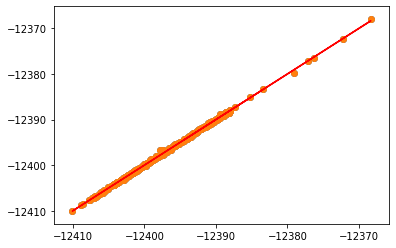

In [14]:
plt.scatter(y_test, yp_test*y_scale+y_mean)
plt.scatter(y_test, wyp_test*y_scale+y_mean)
plt.plot(y_test, y_test, color='r')
plt.show()

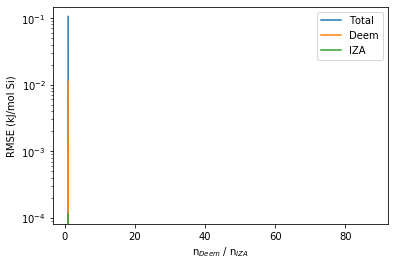

In [15]:
plt.semilogy(x_plot, rmse_train, label='Total')
plt.semilogy(x_plot, rmse_train_deem, label='Deem')
plt.semilogy(x_plot, rmse_train_iza, label='IZA')
plt.ylabel('RMSE (kJ/mol Si)')
plt.xlabel(r'n$_{Deem}$ / n$_{IZA}$')
plt.legend()
plt.show()

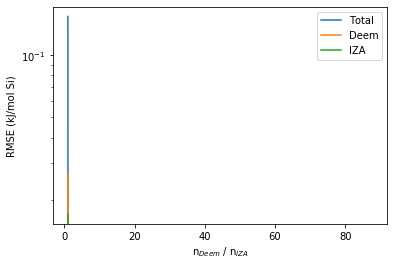

In [16]:
plt.semilogy(x_plot, rmse_test, label='Total')
plt.semilogy(x_plot, rmse_test_deem, label='Deem')
plt.semilogy(x_plot, rmse_test_iza, label='IZA')
plt.ylabel('RMSE (kJ/mol Si)')
plt.xlabel(r'n$_{Deem}$ / n$_{IZA}$')
plt.legend()
plt.show()

In [17]:
rmse_test

array([0.15360361, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

# PCA

In [18]:
from sklearn.decomposition._base import _BasePCA

In [19]:
class WeightedPCA(_BasePCA):
    def __init__(self, n_components=None, tol=1.0E-12):
        self.n_components = n_components
        self.tol = tol
        
    def fit(self, X, sample_weights=None):
        if sample_weights is None:
            sample_weights = np.ones(len(X))
        self.mean_ = np.dot(sample_weights, X) / np.sum(sample_weights)
        C = np.cov(X, rowvar=False, aweights=sample_weights)
        v, U = np.linalg.eigh(C)
        
        U = U[:, v > self.tol]
        U = np.flip(U, axis=1)
        self.U_ = U[:, 0:self.n_components]
        v = v[v > self.tol]
        v = np.flip(v)
        self.v_ = v[0:self.n_components]
        
    def transform(self, X):
        return (X - self.mean_) @ self.U_

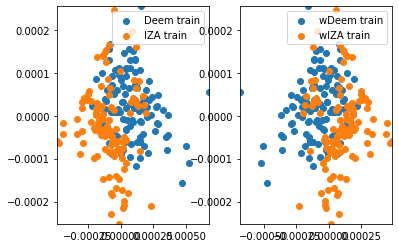

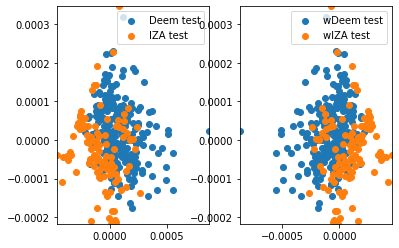

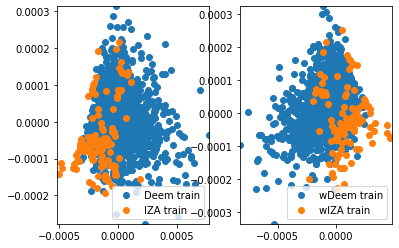

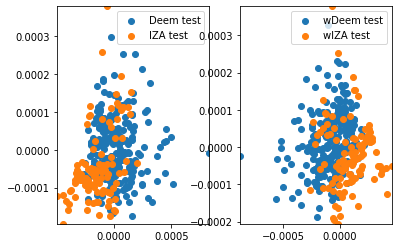

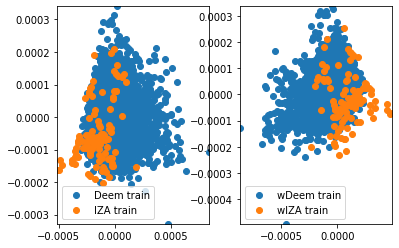

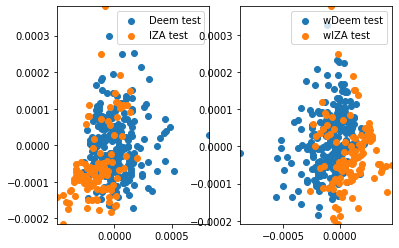

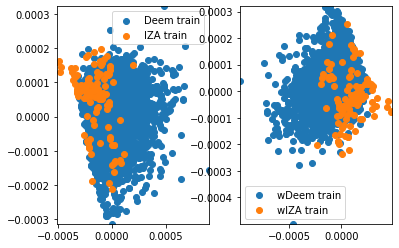

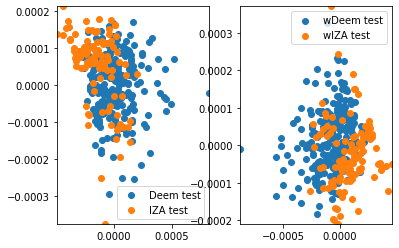

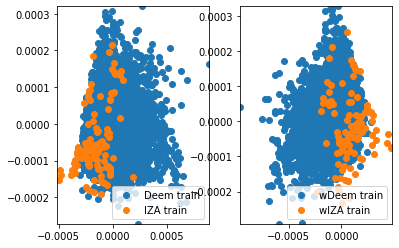

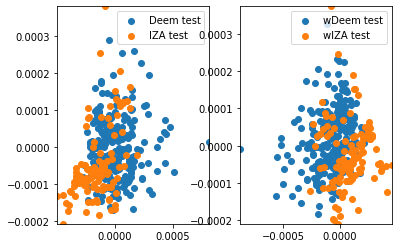

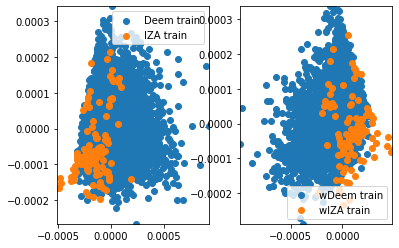

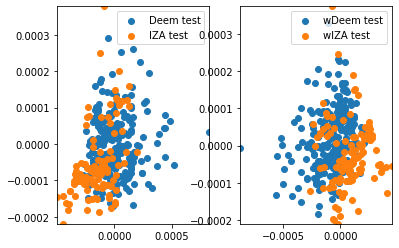

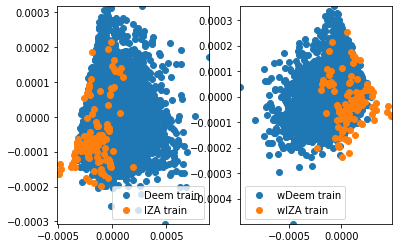

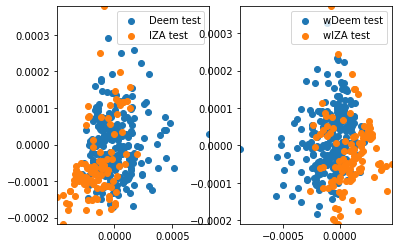

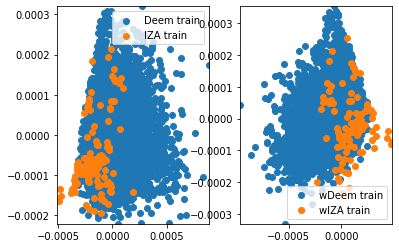

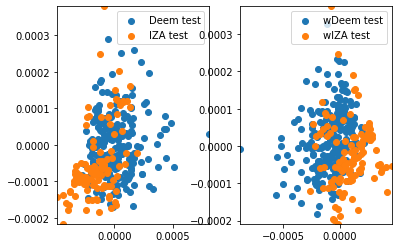

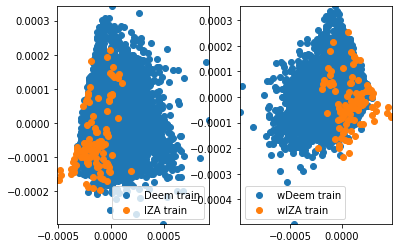

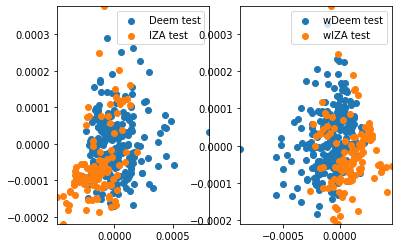

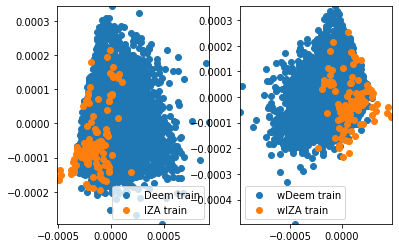

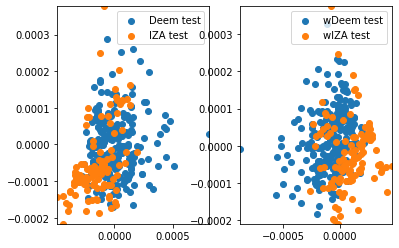

In [20]:
for ndx, n in enumerate(n_train_deem):
    idxs = np.arange(0, len(deem_train))
    np.random.shuffle(idxs)
    idxs = idxs[0:n]
        
    X_train = np.vstack((iza_train, deem_train[idxs]))
    
    wts_iza = np.ones(len(iza_train)) * len(X_train) / len(iza_train)
    wts_deem = np.ones(len(deem_train[idxs])) * len(X_train) / len(deem_train[idxs])
    wts = np.concatenate((wts_iza, wts_deem))
    wts /= np.sum(wts)
    
    #X_mean = 0.0
    #X_mean = np.mean(X_train, axis=0)
    #X_mean = 0.5 * (np.mean(iza_train, axis=0) + np.mean(deem_train[idxs], axis=0))
    X_mean = np.average(X_train, weights=wts, axis=0)
    
    pca = PCA(n_components=2)
    pca.fit(X_train - X_mean)
    
    T_train = pca.transform(X_train - X_mean)
    T_test = pca.transform(X_test - X_mean)
    
    wpca = WeightedPCA(n_components=2)
    wpca.fit(X_train - X_mean, sample_weights=wts)
    
    wT_train = wpca.transform(X_train - X_mean)
    wT_test = wpca.transform(X_test - X_mean)
    
    fig, (axs, waxs) = plt.subplots(1, 2)
    axs.scatter(T_train[n_train_iza:, 0], T_train[n_train_iza:, 1], label='Deem train')
    axs.scatter(T_train[0:n_train_iza, 0], T_train[0:n_train_iza, 1], label='IZA train')
    axs.set_xlim((np.amin(T_train[:, 0]), np.amax(T_train[:, 0])))
    axs.set_ylim((np.amin(T_train[:, 1]), np.amax(T_train[:, 1])))
    axs.legend()
    waxs.scatter(wT_train[n_train_iza:, 0], wT_train[n_train_iza:, 1], label='wDeem train')
    waxs.scatter(wT_train[0:n_train_iza, 0], wT_train[0:n_train_iza, 1], label='wIZA train')
    waxs.set_xlim((np.amin(wT_train[:, 0]), np.amax(wT_train[:, 0])))
    waxs.set_ylim((np.amin(wT_train[:, 1]), np.amax(wT_train[:, 1])))
    waxs.legend()
    plt.show()
    
    fig, (axs, waxs) = plt.subplots(1, 2)
    axs.scatter(T_test[n_test_iza:, 0], T_test[n_test_iza:, 1], label='Deem test')
    axs.scatter(T_test[0:n_test_iza, 0], T_test[0:n_test_iza, 1], label='IZA test')
    axs.set_xlim((np.amin(T_test[:, 0]), np.amax(T_test[:, 0])))
    axs.set_ylim((np.amin(T_test[:, 1]), np.amax(T_test[:, 1])))
    axs.legend()
    waxs.scatter(wT_test[n_test_iza:, 0], wT_test[n_test_iza:, 1], label='wDeem test')
    waxs.scatter(wT_test[0:n_test_iza, 0], wT_test[0:n_test_iza, 1], label='wIZA test')
    waxs.set_xlim((np.amin(wT_test[:, 0]), np.amax(wT_test[:, 0])))
    waxs.set_ylim((np.amin(wT_test[:, 1]), np.amax(wT_test[:, 1])))
    waxs.legend()
    plt.show()

# SVM

In [89]:
dfs_deem = []
dfs_iza = []

for ndx, n in enumerate(n_train_deem[-1:]):
    idxs = np.arange(0, len(deem_train))
    np.random.shuffle(idxs)
    idxs = idxs[0:n]
        
    X_train = np.vstack((iza_train, deem_train[idxs]))
    y_train = np.concatenate((iza_cantons_train, deem_cantons_train[idxs]))
    
    wt_iza = len(X_train) / len(iza_train)
    wt_deem = len(X_train) / len(deem_train[idxs])
    wts_iza = np.ones(len(iza_train)) * wt_iza
    wts_deem = np.ones(len(deem_train[idxs])) * wt_deem
    wts = np.concatenate((wts_iza, wts_deem))
    wts /= np.sum(wts)
    
    #X_mean = 0.0
    #X_mean = np.mean(X_train, axis=0)
    #X_mean = 0.5 * (np.mean(iza_train, axis=0) + np.mean(deem_train[idxs], axis=0))
    X_mean = np.average(X_train, weights=wts, axis=0)
    X_scale = np.linalg.norm(X_train - X_mean) / np.sqrt(len(X_train))
    
    svc = LinearSVC(C=1.0E-2, class_weight={1: wt_iza, 2: wt_deem})
    svc.fit((X_train - X_mean) / X_scale, y_train)
    
    df_deem = svc.decision_function((np.vstack((deem_train, deem_test)) - X_mean) / X_scale)
    df_iza = svc.decision_function((np.vstack((iza_train, iza_test)) - X_mean) / X_scale)
    
    dfs_deem.append(df_deem)
    dfs_iza.append(df_iza)
    
    yp_train = svc.predict((X_train - X_mean) / X_scale) 
    yp_test = svc.predict((X_test - X_mean) / X_scale)
    
    cm_train = confusion_matrix(y_train, yp_train)
    cm_test = confusion_matrix(yc_test, yp_test)
    
    print(f'===== IZA Train: {n_train_iza} ----- Deem Train: {n} =====')
    print('Train')
    print(cm_train)
    print('Test')
    print(cm_test)
    print()

===== IZA Train: 114 ----- Deem Train: 10000 =====
Train
[[ 112    2]
 [ 478 9522]]
Test
[[101  14]
 [ 16 234]]



In [31]:
x = 100*np.random.rand(100, 20)
w = np.random.rand(100)
w /= np.sum(w)

k = x @ x.T
kc = k - np.average(k, weights=w, axis=0) - np.average(k, weights=w, axis=1)[:, np.newaxis] + np.average(k, weights=np.outer(w, w))
kc /= np.trace(kc) / len(x)
# kc /= np.trace(kc) / np.outer(np.sqrt(w), np.sqrt(w))

xwmean = np.dot(w, x)
xwscale = (x - xwmean) / np.linalg.norm((x-xwmean)) * np.sqrt(len(x))
# xwscale = np.sqrt(w)[:, np.newaxis] * (x - xwmean) / np.linalg.norm((x-xwmean)) # This preprocessing trick works with PCA and LR, but not SVM
kw = xwscale @ xwscale.T

print(kc)
print(np.trace(kc))
print(kw)
print(np.trace(kw))
print(kc/kw)

[[ 0.9751203   0.04019583  0.39079801 ...  0.21699835  0.34631873
  -0.02305881]
 [ 0.04019583  1.13988395 -0.52817108 ... -0.18095511  0.1016368
   0.22946872]
 [ 0.39079801 -0.52817108  0.94795987 ...  0.30272292 -0.19725714
  -0.20685132]
 ...
 [ 0.21699835 -0.18095511  0.30272292 ...  0.97719786  0.22911927
   0.06252498]
 [ 0.34631873  0.1016368  -0.19725714 ...  0.22911927  1.38441833
   0.23653947]
 [-0.02305881  0.22946872 -0.20685132 ...  0.06252498  0.23653947
   0.94316713]]
100.00000000000001
[[ 0.9751203   0.04019583  0.39079801 ...  0.21699835  0.34631873
  -0.02305881]
 [ 0.04019583  1.13988395 -0.52817108 ... -0.18095511  0.1016368
   0.22946872]
 [ 0.39079801 -0.52817108  0.94795987 ...  0.30272292 -0.19725714
  -0.20685132]
 ...
 [ 0.21699835 -0.18095511  0.30272292 ...  0.97719786  0.22911927
   0.06252498]
 [ 0.34631873  0.1016368  -0.19725714 ...  0.22911927  1.38441833
   0.23653947]
 [-0.02305881  0.22946872 -0.20685132 ...  0.06252498  0.23653947
   0.94316713]]

In [37]:
x = 100*np.random.rand(100, 20)
w = np.random.rand(100)
w /= np.sum(w)
xwmean = np.dot(w, x)

# This needs to be sqrt
#xwscale = w[: , np.newaxis]*(x-xwmean) / np.linalg.norm(w[:, np.newaxis]*(x-xwmean)) ###
xwscale = np.sqrt(w)[:, np.newaxis] * (x-xwmean) / np.linalg.norm((x-xwmean)) * np.sqrt(len(x))

C = np.cov(x, aweights=w, rowvar=False, bias=False)
print(C)
# v, U = np.linalg.eigh(C)
# print(v)
# print(U)
print()

Cw = xwscale.T @ xwscale #* (np.sqrt(w[:, np.newaxis]).T @ np.sqrt(w[:, np.newaxis]))
#Cw *= np.linalg.norm(w[:, np.newaxis]*(x-xwmean))**2 ###
#Cw /= (1.0 - np.sum(w**2)) ###
Cw *= np.linalg.norm((x-xwmean))**2 / len(x)
Cw /= (1.0 - np.sum(w**2))
print(Cw)
# wv, wU = np.linalg.eigh(Cw)
# print(wv * np.linalg.norm(np.sqrt(w)[:, np.newaxis]*(x-xwmean))**2 / (1.0 - np.sum(w**2)))
# print(wU)
print(C/Cw)

[[ 6.49868275e+02 -1.29827313e+02  4.60641204e+01  5.90019521e+01
  -1.32937826e+02  4.49893491e+01 -2.99349559e+01  5.04214303e+01
   1.05957461e+02  8.73573223e+01 -8.50412721e+01  2.75941995e+01
   7.42220438e+01  6.17531431e+01  7.15398181e+01  3.83775743e+01
   2.64836216e+01  4.73517525e+01  3.35696660e+01  6.50473545e+00]
 [-1.29827313e+02  8.39892184e+02 -2.20144467e+02  3.95699067e+01
  -1.12897997e+02 -1.04328226e+02 -4.44562077e+01  8.50595798e+01
   1.78146851e+02 -2.76048465e+01 -1.50755333e+01  1.34258969e+02
  -1.22600667e+01 -8.12155035e+01  5.58976843e+01 -2.79538335e+01
   4.84064631e+01  1.02689566e+02  3.52275160e+01  8.45928659e+01]
 [ 4.60641204e+01 -2.20144467e+02  9.88203259e+02 -8.19665181e-01
  -2.87663734e+01 -5.72314920e+01 -1.93818391e+02 -5.80194038e+01
   8.24706178e+01  1.01096262e+02  9.26471885e+01 -1.84542128e+02
  -1.04086264e+02 -4.96433595e+01  8.25116430e+01 -3.62354033e+00
   4.07148360e+01 -8.87319331e+00  9.96382848e+01 -1.90207813e+02]
 [ 5.90

In [53]:
x = np.random.rand(100, 20) * 1.0E+7
w = np.random.rand(100)
w /= np.sum(w)
xwmean = np.dot(w, x)

C = np.cov(x, rowvar=False, bias=True)
Cw = np.cov(x, rowvar=False, bias=True, aweights=w)

v = np.sum(np.var(x, axis=0))
vw = np.sum(np.average((x-xwmean)**2, weights=w, axis=0))

print(np.trace(C), v)
print(np.trace(Cw), vw)

163685219247274.88 163685219247274.88
164039624866018.38 164039624866018.38


In [54]:
print((x-xwmean)/vw)
print((x-xwmean) / np.linalg.norm(x-xwmean) * np.sqrt(len(x)))

[[-5.78776518e-09 -6.51828103e-09 -8.99824731e-09 ... -6.67270635e-10
  -3.07321196e-08 -1.75495346e-08]
 [ 3.10299136e-10  9.21178306e-09 -1.89588960e-09 ...  3.37715231e-08
  -1.55196325e-08 -2.24630927e-08]
 [ 1.48818300e-08 -7.88965032e-09  1.68108593e-08 ... -1.14052927e-08
  -3.34892620e-08  6.40314580e-09]
 ...
 [-2.56980261e-09  1.53607547e-08 -1.95615117e-08 ... -1.82400562e-08
   2.18670216e-08  1.09432399e-08]
 [-6.61873847e-10 -1.23842245e-08  5.12019145e-09 ... -2.60612693e-09
   2.63302564e-08  1.19647712e-08]
 [ 2.23881651e-08  2.44555502e-08 -1.35702650e-08 ...  1.28081741e-08
   1.23732754e-08 -2.82902579e-08]]
[[-0.07413907 -0.0834967  -0.11526412 ... -0.00854748 -0.39366676
  -0.22480286]
 [ 0.00397481  0.11799944 -0.02428562 ...  0.43260036 -0.19880059
  -0.28774367]
 [ 0.19063058 -0.10106342  0.21534071 ... -0.14609746 -0.4289847
   0.08202186]
 ...
 [-0.03291819  0.19676542 -0.25057552 ... -0.23364818  0.28010823
   0.14017874]
 [-0.00847835 -0.1586372   0.0655877

# PCovR

In [90]:
class WeightedPCovR(object):
    def __init__(self, mixing=0.5, n_components=None, alpha=1.0E-6, tol=1.0E-12):
        self.mixing = mixing
        self.n_components = n_components
        self.alpha = alpha
        self.tol = tol
        
    def fit(self, X, y, sample_weights=None):
        if sample_weights is None:
            sample_weights = np.ones(len(X))
            
        sample_weights = sample_weights / np.sum(sample_weights)
        
        self.X_mean_ = np.dot(sample_weights, X)
        X = X - self.X_mean_
        self.X_scale_ = np.linalg.norm(X) / np.sqrt(len(X))
        X = np.sqrt(sample_weights[:, np.newaxis]) * X / self.X_scale_
        
        self.y_mean_ = np.dot(sample_weights, y)
        y = y - self.y_mean_
        self.y_scale_ = np.linalg.norm(y) / np.sqrt(len(y))
        y = np.sqrt(sample_weights) * y / self.y_scale_
                
        Cx = X @ X.T
        
        ridge = Ridge(alpha=self.alpha, fit_intercept=False, normalize=False)
        
        # Don't need to pass weights here since they are included
        # in the preprocessing above, i.e.,
        # the preprocessing above should equate to 
        # weighted ridge regression
        ridge.fit(X, y)
        yy = ridge.predict(X).reshape(-1, 1)
        
        Cy = yy @ yy.T

        C = mixing * Cx + (1.0 - mixing) * Cy
        
        v, U = np.linalg.eigh(C)
        
        U = U[:, v > self.tol]
        U = np.flip(U, axis=1)
        self.U_ = U[:, 0:self.n_components]
        v = v[v > self.tol]
        v = np.flip(v)
        self.v_ = v[0:self.n_components]
        self.PXT_ = self.mixing * X.T + (1.0 - self.mixing) * ridge.coef_.reshape(-1, 1) @ yy.T
        self.PXT_ = self.PXT_ @ self.U_ @ np.diagflat(1.0 / np.sqrt(self.v_))
        self.PTY_ = np.diagflat(1.0 / np.sqrt(self.v_)) @ self.U_.T @ y
        
    def predict(self, X):
        return (X - self.X_mean_) / self.X_scale_ @ self.PXT_ @ self.PTY_ * self.y_scale_ + self.y_mean_
        
    def transform(self, X):
        return (X - self.X_mean_) / self.X_scale_ @ self.PXT_

In [91]:
rmse_train = np.zeros(len(n_train_deem))
rmse_train_deem = np.zeros(len(n_train_deem))
rmse_train_iza = np.zeros(len(n_train_deem))
rmse_test = np.zeros(len(n_train_deem))
rmse_test_deem = np.zeros(len(n_train_deem))
rmse_test_iza = np.zeros(len(n_train_deem))

wrmse_train = np.zeros(len(n_train_deem))
wrmse_train_deem = np.zeros(len(n_train_deem))
wrmse_train_iza = np.zeros(len(n_train_deem))
wrmse_test = np.zeros(len(n_train_deem))
wrmse_test_deem = np.zeros(len(n_train_deem))
wrmse_test_iza = np.zeros(len(n_train_deem))

In [112]:
mixing = 0.0

for ndx, n in enumerate(n_train_deem[-1:]):
    idxs = np.arange(0, len(deem_train))
    np.random.shuffle(idxs)
    idxs = idxs[0:n]
        
    X_train = np.vstack((iza_train, deem_train[idxs]))
    y_train = np.concatenate((dfs_iza[ndx][0:n_train_iza], dfs_deem[ndx][0:len(deem_train)][idxs]))
    y_test = np.concatenate((dfs_iza[ndx][n_train_iza:], dfs_deem[ndx][len(deem_train):]))
    
    wts_iza = np.ones(len(iza_train)) * len(X_train) / len(iza_train)
    wts_deem = np.ones(len(deem_train[idxs])) * len(X_train) / len(deem_train[idxs])
    wts = np.concatenate((wts_iza, wts_deem))
    wts /= np.sum(wts)
    
    X_mean = 0.0
    #X_mean = np.mean(X_train, axis=0)
    #X_mean = 0.5 * (np.mean(iza_train, axis=0) + np.mean(deem_train[idxs], axis=0))
    
    X_scale = 1.0
    
    y_mean = 0.0
    #y_mean = np.mean(y_train, axis=0)
    #y_mean = 0.5 * (np.mean(iza_energies_train) + np.mean(deem_energies_train))
    
    y_scale = 1.0
    
    pcovr = WeightedPCovR(mixing=mixing, n_components=2)
    pcovr.fit(
        (X_train - X_mean) / X_scale, 
        (y_train - y_mean) / y_scale
    )
    
    T_train = pcovr.transform((X_train - X_mean) / X_scale)
    T_test = pcovr.transform((X_test - X_mean) / X_scale)
    
    yp_train = pcovr.predict((X_train - X_mean) / X_scale)
    yp_test = pcovr.predict((X_test - X_mean) / X_scale)
    
    rmse_train[ndx] = mean_squared_error(y_train, yp_train * y_scale + y_mean, squared=False)
    rmse_train_iza[ndx] = mean_squared_error(y_train[0:n_train_iza], yp_train[0:n_train_iza] * y_scale + y_mean)
    rmse_train_deem[ndx] = mean_squared_error(y_train[n_train_iza:], yp_train[n_train_iza:] * y_scale + y_mean)

    rmse_test[ndx] = mean_squared_error(y_test, yp_test * y_scale + y_mean, squared=False)
    rmse_test_iza[ndx] = mean_squared_error(y_test[0:n_test_iza], yp_test[0:n_test_iza] * y_scale + y_mean)
    rmse_test_deem[ndx] = mean_squared_error(y_test[n_test_iza:], yp_test[n_test_iza:] * y_scale + y_mean)
    
    wpcovr = WeightedPCovR(mixing=mixing, n_components=2)
    wpcovr.fit(
        (X_train - X_mean) / X_scale, 
        (y_train - y_mean) / y_scale, 
        sample_weights=wts
    )
    
    wT_train = wpcovr.transform((X_train - X_mean) / X_scale)
    wT_test = wpcovr.transform((X_test - X_mean) / X_scale)
    
    wyp_train = wpcovr.predict((X_train - X_mean) / X_scale)
    wyp_test = wpcovr.predict((X_test - X_mean) / X_scale)
    
    wrmse_train[ndx] = mean_squared_error(y_train, wyp_train * y_scale + y_mean, squared=False)
    wrmse_train_iza[ndx] = mean_squared_error(y_train[0:n_train_iza], wyp_train[0:n_train_iza] * y_scale + y_mean)
    wrmse_train_deem[ndx] = mean_squared_error(y_train[n_train_iza:], wyp_train[n_train_iza:] * y_scale + y_mean)

    wrmse_test[ndx] = mean_squared_error(y_test, wyp_test * y_scale + y_mean, squared=False)
    wrmse_test_iza[ndx] = mean_squared_error(y_test[0:n_test_iza], wyp_test[0:n_test_iza] * y_scale + y_mean)
    wrmse_test_deem[ndx] = mean_squared_error(y_test[n_test_iza:], wyp_test[n_test_iza:] * y_scale + y_mean)
    
    print(rmse_train_iza[ndx], rmse_train_deem[ndx])
    print(rmse_test_iza[ndx], rmse_test_deem[ndx])
    print(wrmse_train_iza[ndx], wrmse_train_deem[ndx])
    print(wrmse_test_iza[ndx], wrmse_test_deem[ndx])
    
#     fig, (axs, waxs) = plt.subplots(1, 2)
#     axs.scatter(T_train[n_train_iza:, 0], T_train[n_train_iza:, 1], label='Deem train')
#     axs.scatter(T_train[0:n_train_iza, 0], T_train[0:n_train_iza, 1], label='IZA train')
#     axs.set_xlim((np.amin(T_train[:, 0]), np.amax(T_train[:, 0])))
#     axs.set_ylim((np.amin(T_train[:, 1]), np.amax(T_train[:, 1])))
#     axs.legend()
#     waxs.scatter(wT_train[n_train_iza:, 0], wT_train[n_train_iza:, 1], label='wDeem train')
#     waxs.scatter(wT_train[0:n_train_iza, 0], wT_train[0:n_train_iza, 1], label='wIZA train')
#     waxs.set_xlim((np.amin(wT_train[:, 0]), np.amax(wT_train[:, 0])))
#     waxs.set_ylim((np.amin(wT_train[:, 1]), np.amax(wT_train[:, 1])))
#     waxs.legend()
#     plt.show()
    
#     fig, (axs, waxs) = plt.subplots(1, 2)
#     axs.scatter(T_test[n_test_iza:, 0], T_test[n_test_iza:, 1], label='Deem test')
#     axs.scatter(T_test[0:n_test_iza, 0], T_test[0:n_test_iza, 1], label='IZA test')
#     axs.set_xlim((np.amin(T_test[:, 0]), np.amax(T_test[:, 0])))
#     axs.set_ylim((np.amin(T_test[:, 1]), np.amax(T_test[:, 1])))
#     axs.legend()
#     waxs.scatter(wT_test[n_test_iza:, 0], wT_test[n_test_iza:, 1], label='wDeem test')
#     waxs.scatter(wT_test[0:n_test_iza, 0], wT_test[0:n_test_iza, 1], label='wIZA test')
#     waxs.set_xlim((np.amin(wT_test[:, 0]), np.amax(wT_test[:, 0])))
#     waxs.set_ylim((np.amin(wT_test[:, 1]), np.amax(wT_test[:, 1])))
#     waxs.legend()
#     plt.show()

4.631411197290294e-07 2.2401711826377832e-08
1.850556140383259e-07 2.4124524483715125e-08
1.2252987961695867e-08 1.2464106386230931e-08
1.7707941549441934e-08 1.266835457967972e-08


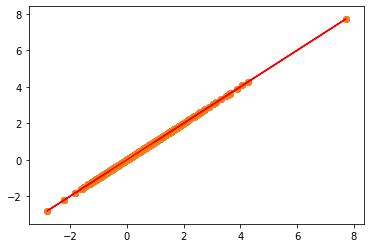

In [117]:
plt.scatter(y_test, yp_test)
plt.scatter(y_test, wyp_test)
plt.plot(y_test, y_test, color='r')
plt.show()

In [114]:
X_mean = np.average(X_train, weights=wts, axis=0)
X_scale = np.linalg.norm(X_train - X_mean) / np.sqrt(len(X_train))

y_mean = np.average(y_train, weights=wts)
y_scale = np.linalg.norm(y_train - y_mean) / np.sqrt(len(y_train))

wridge = Ridge(alpha=1.0E-6, fit_intercept=False, normalize=False)
wridge.fit((X_train - X_mean) / X_scale, (y_train - y_mean) / y_scale, sample_weight=wts)
wyp_ridge_test = wridge.predict((X_test - X_mean) / X_scale) * y_scale + y_mean

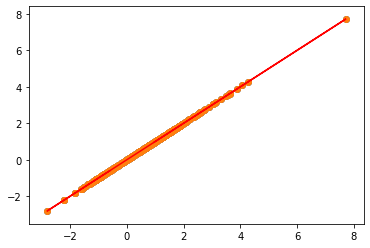

In [116]:
plt.scatter(y_test, wyp_test)
plt.scatter(y_test, wyp_ridge_test)
plt.plot(y_test, y_test, color='r')
plt.show()

In [124]:
np.column_stack((wyp_test, wyp_ridge_test))

array([[-6.04546558e-01, -6.04536045e-01],
       [-1.62362884e+00, -1.62360470e+00],
       [-1.18430524e+00, -1.18428697e+00],
       [-1.00762828e+00, -1.00761238e+00],
       [-7.77516155e-01, -7.77503329e-01],
       [-5.55805068e-01, -5.55795207e-01],
       [-1.07358877e+00, -1.07357198e+00],
       [-9.45262532e-01, -9.45247463e-01],
       [-1.06005531e+00, -1.06003871e+00],
       [-9.57765292e-01, -9.57750056e-01],
       [-1.24788982e+00, -1.24787071e+00],
       [-6.37456207e-01, -6.37445253e-01],
       [-9.22661516e-01, -9.22646749e-01],
       [-6.35641907e-01, -6.35630978e-01],
       [ 5.22717784e-01,  5.22713225e-01],
       [-1.26558427e+00, -1.26556492e+00],
       [-8.29296490e-01, -8.29282972e-01],
       [-9.28355368e-01, -9.28340525e-01],
       [ 6.71214376e-01,  6.71207832e-01],
       [-3.46446527e-01, -3.46439465e-01],
       [-9.27261860e-01, -9.27247032e-01],
       [ 1.25275467e+00,  1.25274035e+00],
       [-1.35209642e+00, -1.35207591e+00],
       [-1.